# Machine Learning Demonstrations - 5

To run these notebooks, you need to install python dependencies:

With pip:

```pip install numpy==1.14.0
pip install scipy==1.0.0
pip install graphviz==0.5.2
pip install matplotlib==2.0.2
pip install scikit_learn==0.19.1
pip install xgboost==0.7.post3```


Graphviz requires to be installed using *conda* also

With conda:

```conda install -c anaconda graphviz```
## Classification using Decision Trees

Decision Trees are a simple but effective algorithm, used for supervised classification and regression problems.

Decision Trees can
- Manage a mixture of discrete, continuous and categorical inputs
- Use data with no normalization/pre-processing (including missing data)
- Produce a highly-interpretable output, which can be easily explained and visualized

A decision tree is a collection of simple hierarchical decision rules, classifying datapoints into categories by *splitting* on feature values. The task of *fitting* a decision tree to data, is therefore the task of finding the sequence of feature splits and the optimal split values.

Further discussion of decision trees can be found on the [Wikipedia article](https://en.wikipedia.org/wiki/Decision_tree) or [Sci-Kit Learn documentation](http://scikit-learn.org/stable/modules/tree.html).

## Breast Cancer Data
The Wisconsin Breast Cancer dataset is a set of 569 samples of fine needle aspirate (FNA) of breast mass. Each sample contains features describing characteristics of the cell nuclei , along with a classification of the sample as either benign or malignant.

### Load data

In [1]:
/ Utility functions
\l ../utils/funcs.q
\l ../utils/graphics.q

In [2]:
data:.p.import[`sklearn.datasets;`:load_breast_cancer][]
X:data[`:data]`
y:data[`:target]`
featnames:getunicode data`:feature_names
/ Inspect data
-1"Shape of feature data is: ",sv[" x "]string shape X;
-1"";show 5#X;-1"";
-1"Distribution of target values is:\n";
show update pcnt:round[;.01]100*num%sum num from select num:count i by target from([]target:y);

Shape of feature data is: 569 x 30

17.99 10.38 122.8 1001  0.1184  0.2776  0.3001 0.1471  0.2419 0.07871 1.095  ..
20.57 17.77 132.9 1326  0.08474 0.07864 0.0869 0.07017 0.1812 0.05667 0.5435 ..
19.69 21.25 130   1203  0.1096  0.1599  0.1974 0.1279  0.2069 0.05999 0.7456 ..
11.42 20.38 77.58 386.1 0.1425  0.2839  0.2414 0.1052  0.2597 0.09744 0.4956 ..
20.29 14.34 135.1 1297  0.1003  0.1328  0.198  0.1043  0.1809 0.05883 0.7572 ..

Distribution of target values is:

target| num pcnt 
------| ---------
0     | 212 37.26
1     | 357 62.74


Classes are quite unbalanced
- 37% are malignant (0)
- 63% are benign (1)

### Split data
50/50 training/test split

In [3]:
\S 123 / random seed
show count each datadict:traintestsplit[X;y;.5]

xtrain| 284
ytrain| 284
xtest | 285
ytest | 285


### Fit model

We fit a DecisionTreeClassifier model, restricting the tree to a maximum depth of 3.

In [4]:
DecisionTreeClassifier:.p.import[`sklearn.tree]`:DecisionTreeClassifier
classifier:DecisionTreeClassifier[`max_depth pykw 3]
classifier[`:fit][datadict.xtrain;datadict.ytrain];

Using the graph visualization software [Graphviz](https://www.graphviz.org/), we can look at the structure of the resulting decision tree.

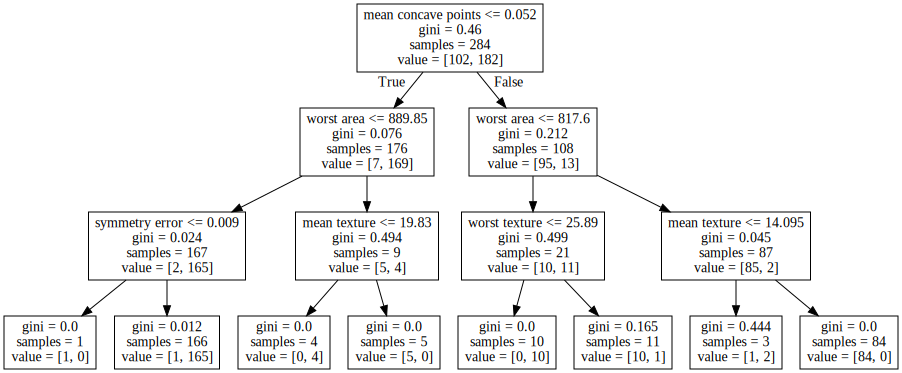

In [5]:
graphviz:.p.import`graphviz
exportgraphviz:.p.import[`sklearn.tree;`:export_graphviz]
dotdata:exportgraphviz[classifier;`out_file pykw (::);`feature_names pykw featnames]
graph:graphviz[`:Source]dotdata
display graph

The decision tree classifier produces a highly interpretable model which can be visualized and understood even by non-technical people.

The algorithm finds the best tree by following a *greedy* strategy.  
It first finds the feature (mean concave points) and split value (0.052) that most effectively partitions the data.  

This divides the dataset of 284 samples into two subsets of 176 samples and 108 samples.
- Of the 176 samples, 7 (4%) are malignant and 169 (96%) are benign.
- Of the 108 samples, 95 (88%) are malignant and 13 (12%) are benign.

So even one split value can provide a very powerful and predictive split between the classification labels.

The algorithm continues splitting the dataset at each node, by finding the feature and split value that most effectively partitions the benign from the malignant samples.

### Evaluate model

The output of the decision tree is a class assignment.

We take a previously unseen sample and pass it through the decision tree. Following the appropriate branch at each split (based on the feature values of the test point), we eventually end up at a *leaf node*, at the bottom of the tree. At this point, we assign the test point the class value of the majority of the test examples included in that leaf.

We can therefore evaluate the performance of the decision tree, on the held-out test data. 

In [6]:
yprob:classifier[`:predict_proba;<]datadict.xtest
ypred:raze {$[2=count x;1?;]x}each{x?max x}each yprob /#TODO ?
dtloss:logloss[datadict.ytest;yprob]
dtacc:accuracy[datadict.ytest;ypred]

-1"Performance of the classifier";
-1"log loss: ",(string dtloss),", accuracy: ",string dtacc;

Performance of the classifier
log loss: 0.9664692, accuracy: 0.9508772


The decision tree classifier achieves 95% accuracy on the test set, a strong performance from such a simple classifier.

### Confusion matrix


With a Confusion Matrix, we can inspect the interaction between
- True positives
- True negatives
- False positives
- False negatives

0| 98 2  
1| 12 173


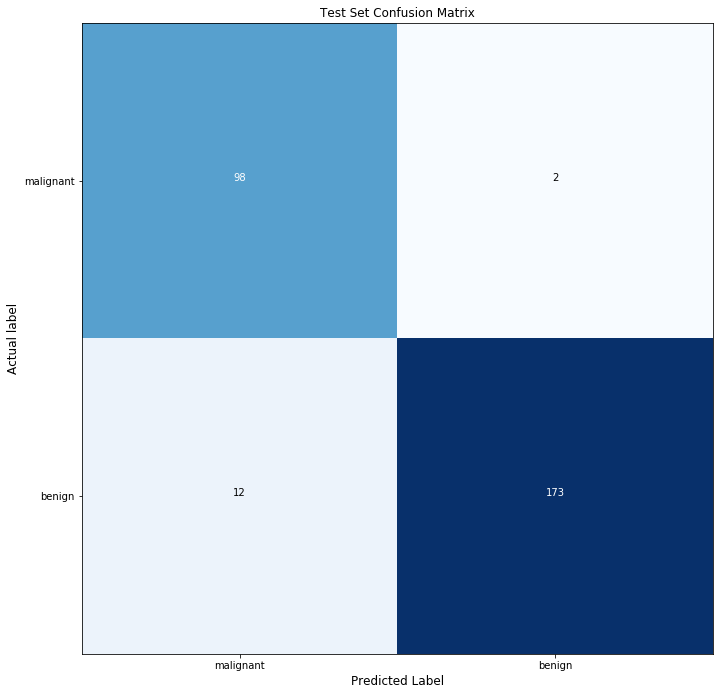

In [7]:
show cnfM:cfm[datadict.ytest;ypred]
displayCM[value cnfM;`malignant`benign;"Test Set Confusion Matrix";()]

The classifier has

```True Positive Rate  TPR = TP/(TP+FN) = 99/(99+3)   = 98%
False Positive Rate FPR = FP/(FP+TN) = 11/(11+172) =  6%```

n.b. We are using _positive_ here to denote the malignant case, which actually has the label 0, rather than 1, in the Wisconsin dataset.

### ROC curve
Rather than using a _majority vote_ system, we could use a threshold other than 50% for assigning the points to classes at the leaf node.  
- By modifying the threshold in favour of a _malignant_ diagnosis, we would increase the true positive rate, but would also increase the false positive rate.  
- By modifying the threshold in favour of a _benign_ diagnosis, we would decrease the false positive rate, but would also decrease the true positive rate.  

The realtionship between the true positive rate (sensitivity) and the false positive rate, is captured in the Receiver Operating Characteristic (ROC) curve.

n.b. 1 - FPR is called the _specificity_ of the model. We therefore have a trade-off between _sensitivity_ and _specificity_.

The area under the curve (AUC) is interpreted as the probability that a classifier will rank a randomly chosen _positive_ instance higher than a randomly chosen _negative_ one.

The optimal classifier would have a false positive rate of 0 and a true positive rate of 1, giving a an AUC curve of 1.

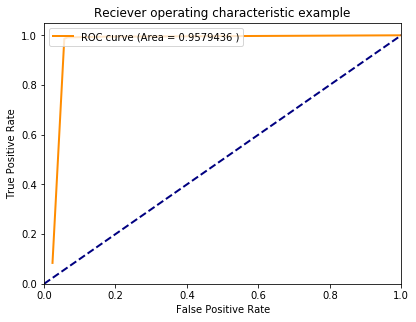

In [8]:
yprob:classifier[`:predict_proba;<;X]
displayROCcurve[y;yprob[;1]]

 With an AUC of 0.96, our classifier is close to optimal.